In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.optimize import minimize

%matplotlib inline

/Users/samhoover/miniconda3/envs/py39/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def xlogx(x):
    if isinstance(x, float):
        if x == 0:
            return 0
        elif x > 0:
            return x * np.log(x)
        else:
            return np.inf
    
    elif isinstance(x, np.ndarray):
        return np.array(
            [s * np.log(s) if s > 0 else 0 if s == 0 else np.inf for s in x]
        )
    
    elif isinstance(x, list):
        return np.array(
            [s * np.log(s) if s > 0 else 0 if s == 0 else np.inf for s in x]
        )
    
    else:
        return ValueError, 'incompatible type, must be either: float, numpy.ndarray, or list'

# Reproducing work from [Polyelectrolyte complex coacervation by electrostatic dipolar interactions](https://doi.org/10.1063/1.5029268) by Adhikari, Leaf, and Muthukumar

## Symmetric case ($n_{1} = n_{2}$, $N_{1} = N_{2}$)

### Indistinguishable ions

In [3]:
def indist_f(phi_p, phi_pi, phi_ni, phi_0, *args, contribs=False):
    N = args[0]
    fSp = xlogx(phi_p) / (2 * N)
    fSi = xlogx(phi_pi) + xlogx(phi_ni)
    fS0 = xlogx(phi_0)

    chi_p0 = args[1]
    fex = chi_p0 * phi_p * phi_0

    l, lB = args[2:4]
    kl2 = 4 * np.pi * (lB / l) * (phi_pi + phi_ni)
    kl = np.sqrt(kl2)
    p1, p2 = args[4:6]
    vdd = -(np.pi * ((lB * p1 * p2) ** 2) * np.exp(-2 * kl) * (4 + 8 * kl + 4 * kl2 + (kl ** 3))) / (9 * (l ** 6))
    fel = vdd * (phi_p ** 2) / 8

    ffli = -(1 / (4 * np.pi)) * (np.log(1 + kl) - kl + 0.5 * kl2)

    if contribs:
        return fSp, fSi, fS0, fex, fel, ffli
    else:
        return fSp + fSi + fS0 + fex + fel + ffli

In [4]:
def indist_objective(s, *args):
    phi_pa, phi_pia, xa = s

    phi_p, phi_pi, phi_ni = args[6:9]
    phi_pb = (phi_p - xa * phi_pa) / (1 - xa)
    phi_pib = (phi_pi - xa * phi_pia) / (1 - xa)
    phi_nia = phi_pia
    phi_nib = (phi_ni - xa * phi_nia) / (1 - xa)
    phi_0a = 1 - phi_pa - phi_pia - phi_nia
    phi_0b = 1 - phi_pb - phi_pib - phi_nib

    _phis = np.array([phi_pb, phi_pib, phi_nia, phi_nib, phi_0a, phi_0b])

    if (np.abs(_phis - 0.5) < 0.5).all():  # if within 0 and 1, calculate free energy
        ftotal = ((xa * indist_f(phi_pa, phi_pia, phi_nia, phi_0a, *args)) 
                  + ((1 - xa) * indist_f(phi_pb, phi_pib, phi_nib, phi_0b, *args)))
        if ftotal < 1000 and np.abs(xa - 0.5) < 0.499:
                return ftotal
        else:
            return np.inf
    else:  # if not, return infinity
        return np.inf

In [5]:
# constants and parameters
eps0 = 625000 / (22468879468420441 * np.pi)  # vacuum permittivity [A^2 s^4 kg^-1 m^-3]
e = 1.602e-19  # electronic charge [A s]
kB = 1.380694e-23  # boltzmann constant [kg m^2 s^-2 K^-1]

N = 100  # degree of polymerization
l = 0.55e-9  # kuhn length [m]
eps = 80  # dielectic constant of medium
T = 298  # temperature [K]
theta = 257  # theta temperature [K]
alpha = 1 / 3  # degree of ionization of polyelectrolytes
achi = 1.7  # reduced chi parameter
p1 = 0.55e-9  # polyanion dipole length [m]
p2 = 0.55e-9  # polycation dipole length [m]

In [6]:
TEMPS = [x + 273 for x in [25, 30, 34]]
PHI_P = np.arange(0.0001, 0.1, 0.0007)
PHI_S = np.arange(0.0001, 0.07, 0.001)
phase = np.zeros((len(PHI_S) * len(PHI_P) * len(TEMPS), 5))

bnd_tol = 0
bnds = (
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
)  # bounds for phi_pa, phi_pia, xa

count = 0
for i, T in enumerate(TEMPS):
    lB = (e ** 2) / (4 * np.pi * eps0 * eps * kB * T)
    t = l / (4 * np.pi * lB)
    chi_p0 = achi / (20 * np.pi * t)
    print(f'T = {T} K, lB = {lB * 1e9:.2f} nm, chi = {chi_p0:.3f}')

    for phi_s in PHI_S:
        for phi_p in PHI_P:
            phi_pi = (phi_s / 2) + phi_p / 2
            phi_ni = (phi_s / 2) + phi_p / 2
            if (phi_pi + phi_ni) <= 0.07:
                if (phi_p + phi_pi + phi_ni) <= 0.9999:
                    args = (
                        N, chi_p0, l, lB, p1, p2, phi_p, phi_pi, phi_ni,
                    )
                    pa, pia, nia, pb, pib, nib = 0, 0, 0, 0, 0, 0
                    results = minimize(
                        indist_objective, x0=(phi_p, phi_pi, 0.1), 
                        args=args, method='Nelder-Mead', 
                        options={'fatol': 1e-12, 'xatol': 1e-12},
                        bounds=bnds,
                    )
                    if results.success:
                        pa, pia, _x = results.x
                        if np.abs(_x - 0.5) < 0.499:
                            pb = (phi_p - _x * pa) / (1 - _x)
                            if np.abs(pa - pb) > 0.0001:
                                pib = (phi_pi - _x * pia) / (1 - _x)
                                nia = pia
                                nib = (phi_ni - _x * nia) / (1 - _x)
                                phase[count, :] = T, pia + nia, pa, pib + nib, pb
            count += 1

T = 298 K, lB = 0.70 nm, chi = 0.433
T = 303 K, lB = 0.69 nm, chi = 0.426
T = 307 K, lB = 0.68 nm, chi = 0.420


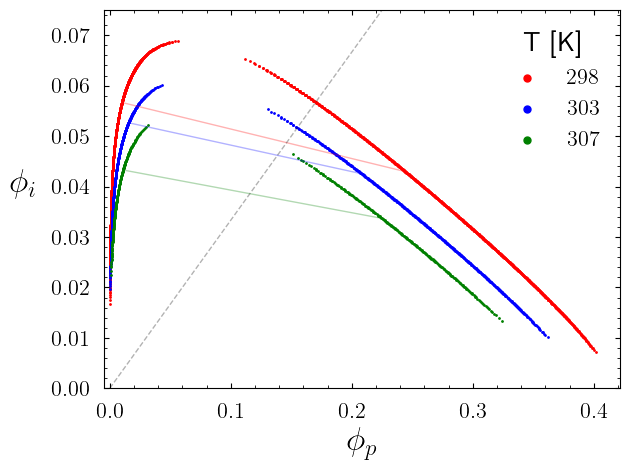

In [7]:
phase_keep = phase[phase.any(axis=1)]

colors = ['red', 'blue', 'green']
fig, ax = plt.subplots()
for i, T in enumerate(sorted(np.unique(phase_keep[:, 0]))):
    data = phase_keep[phase_keep[:, 0] == T, 1:]
    ax.scatter(data[:, 1], data[:, 0], s=1, color=colors[i], label=f'${T:.0f}$')
    ax.scatter(data[:, 3], data[:, 2], s=1, color=colors[i])
    tie_idx = -1
    ax.plot(
        [data[tie_idx, 1], data[tie_idx, 3]], 
        [data[tie_idx, 0], data[tie_idx, 2]],
        color=colors[i], linewidth=1, alpha=0.3
    )

ax.plot([0, 0.25], alpha * np.array([0, 0.25]), color='black', linestyle='dashed', linewidth=1, alpha=0.3)

ax.set_xlim(-0.005, None)
ax.set_ylim(0, 0.075)
ax.set_xlabel('$\phi_{p}$', fontsize=24)
ax.set_ylabel('$\phi_{i}$', fontsize=24, rotation=0, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.legend(fontsize=16, markerscale=5, title='T [K]', title_fontsize=20, framealpha=0)

fig.tight_layout()

### Distinguishable ions

In [8]:
def dist_f(phi_p, phi_c1, phi_c2, phi_pi, phi_ni, phi_0, *args, contribs=False):
    N = args[0]
    fSp = xlogx(phi_p) / (2 * N)
    fSi = xlogx(phi_c1) + xlogx(phi_c2) + xlogx(phi_pi) + xlogx(phi_ni)
    fS0 = xlogx(phi_0)

    chi_p0 = args[1]
    fex = chi_p0 * phi_p * phi_0

    l, lB = args[2:4]
    kl2 = 4 * np.pi * (lB / l) * (phi_c1 + phi_c2 + phi_pi + phi_ni)
    kl = np.sqrt(kl2)
    p1, p2 = args[4:6]
    vdd = -(np.pi * ((lB * p1 * p2) ** 2) * np.exp(-2 * kl) * (4 + 8 * kl + 4 * kl2 + (kl ** 3))) / (9 * (l ** 6))
    fel = vdd * (phi_p ** 2) / 8

    ffli = -(1 / (4 * np.pi)) * (np.log(1 + kl) - kl + 0.5 * kl2)

    if contribs:
        return fSp, fSi, fS0, fex, fel, ffli
    else:
        return fSp + fSi + fS0 + fex + fel + ffli

In [9]:
def dist_objective(s, *args):
    phi_pa, phi_c1a, phi_c2a, phi_pia, xa = s

    phi_p, phi_c1, phi_c2, phi_pi, phi_ni = args[6:11]
    phi_pb = (phi_p - xa * phi_pa) / (1 - xa)
    phi_c1b = (phi_c1 - xa * phi_c1a) / (1 - xa)
    phi_c2b = (phi_c2 - xa * phi_c2a) / (1 - xa)
    phi_pib = (phi_pi - xa * phi_pia) / (1 - xa)
    phi_nia = phi_pia
    phi_nib = (phi_ni - xa * phi_nia) / (1 - xa)
    phi_0a = 1 - phi_pa - phi_c1a - phi_c2a - phi_pia - phi_nia
    phi_0b = 1 - phi_pb - phi_c1b - phi_c2b - phi_pib - phi_nib

    _phis = np.array([phi_pb, phi_c1b, phi_c2b, phi_pib, phi_nib, phi_0a, phi_0b])

    if (np.abs(_phis - 0.5) < 0.5).all():  # if within 0 and 1, calculate free energy
        ftotal = ((xa * dist_f(phi_pa, phi_c1a, phi_c2a, phi_pia, phi_nia, phi_0a, *args))
                   + ((1 - xa) * dist_f(phi_pb, phi_c1b, phi_c2b, phi_pib, phi_nib, phi_0b, *args)))
        if ftotal < 1000 and np.abs(xa - 0.5) < 0.499:
                return ftotal
        else:
            return np.inf
    else:  # if not, return infinity
        return np.inf

In [10]:
# constants and parameters
eps0 = 625000 / (22468879468420441 * np.pi)  # vacuum permittivity [A^2 s^4 kg^-1 m^-3]
e = 1.602e-19  # electronic charge [A s]
kB = 1.380694e-23  # boltzmann constant [kg m^2 s^-2 K^-1]

N = 100  # degree of polymerization
l = 0.55e-9  # kuhn length [m]
eps = 80  # dielectic constant of medium
T = 298  # temperature [K]
theta = 257  # theta temperature [K]
alpha = 1 / 3  # degree of ionization of polyelectrolytes
achi = 1.7  # reduced chi parameter
p1 = 0.55e-9  # polyanion dipole length [m]
p2 = 0.55e-9  # polycation dipole length [m]

In [11]:
TEMPS = [x + 273 for x in [25, 30, 34]]
PHI_P = np.arange(0.00001, 0.1, 0.0003)
PHI_S = np.arange(0.00001, 0.07, 0.002)
phase = np.zeros((len(PHI_S) * len(PHI_P) * len(TEMPS), 5))

bnd_tol = 0
bnds = (
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
)  # bounds for phi_pa, phi_c1a, phi_c2a, phi_pia, xa

count = 0
for i, T in enumerate([x + 273 for x in [25, 30, 34]]):
    lB = (e ** 2) / (4 * np.pi * eps0 * eps * kB * T)
    t = l / (4 * np.pi * lB)
    chi_p0 = achi / (20 * np.pi * t)
    print(f'T = {T} K, lB = {lB * 1e9:.2f} nm, chi = {chi_p0:.3f}')

    for phi_s in PHI_S:
        for phi_p in PHI_P:
            phi_c1 = phi_p / 2
            phi_c2 = phi_p / 2
            phi_pi = phi_s / 2
            phi_ni = phi_s / 2
            if (phi_c1 + phi_c2 + phi_pi + phi_ni) <= 0.07:
                if ((2 * phi_p) + phi_s) <= 0.9999:
                    args = (
                        N, chi_p0, l, lB, p1, p2, phi_p, phi_c1, phi_c2, phi_pi, phi_ni,
                    )
                    pa, pb, = np.inf, np.inf
                    results = minimize(
                        dist_objective, x0=(phi_p, phi_c1, phi_c2, phi_pi, 0.1), 
                        args=args, method='Nelder-Mead', 
                        options={'fatol': 1e-16, 'xatol': 1e-16},
                        bounds=bnds,
                    )
                    if results.success:
                        pa, c1a, c2a, pia, _x = results.x
                        pb = (phi_p - _x * pa) / (1 - _x)
                        if np.abs(pa - pb) > 0.001:
                            c1b = (phi_c1 - _x * c1a) / (1 - _x)
                            c2b = (phi_c2 - _x * c2a) / (1 - _x)
                            pib = (phi_pi - _x * pia) / (1 - _x)
                            nia = pia
                            nib = (phi_ni - _x * nia) / (1 - _x)
                            phase[count, :] = T, c1a + c2a + pia + nia, pa, c1b + c2b + pib + nib, pb
            count += 1

T = 298 K, lB = 0.70 nm, chi = 0.433
T = 303 K, lB = 0.69 nm, chi = 0.426
T = 307 K, lB = 0.68 nm, chi = 0.420


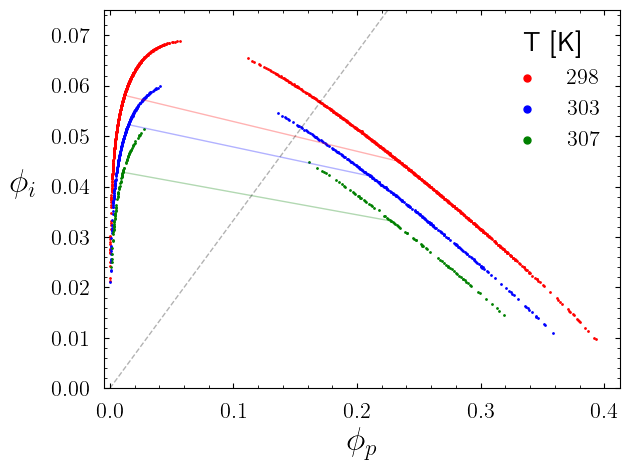

In [12]:
phase_keep = phase[phase.any(axis=1)]

colors = ['red', 'blue', 'green']
fig, ax = plt.subplots()
for i, T in enumerate(sorted(np.unique(phase_keep[:, 0]))):
    data = phase_keep[phase_keep[:, 0] == T, 1:]
    ax.scatter(data[:, 1], data[:, 0], s=1, color=colors[i], label=f'${T:.0f}$')
    ax.scatter(data[:, 3], data[:, 2], s=1, color=colors[i])
    tie_idx = -1
    ax.plot(
        [data[tie_idx, 1], data[tie_idx, 3]], 
        [data[tie_idx, 0], data[tie_idx, 2]],
        color=colors[i], linewidth=1, alpha=0.3
    )

ax.plot([0, 0.25], alpha * np.array([0, 0.25]), color='black', linestyle='dashed', linewidth=1, alpha=0.3)

ax.set_xlim(-0.005, None)
ax.set_ylim(0, 0.075)
ax.set_xlabel('$\phi_{p}$', fontsize=24)
ax.set_ylabel('$\phi_{i}$', fontsize=24, rotation=0, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.legend(fontsize=16, markerscale=5, title='T [K]', title_fontsize=20, framealpha=0)

fig.tight_layout()

The above phase diagrams assumed a constant dielectric constant with changing temperature, something we know is aphysical for water.

The well known empirical model for the dielectric constant for water comes from [Dielectric Constant of Water from 0 C to 100 C](https://nvlpubs.nist.gov/nistpubs/jres/56/jresv56n1p1_A1b.pdf) by Malmberg and Maryott

$\varepsilon = 87.740 - 0.40008t + 9.398(10^{-4})t^{2} - 1.410(10^{-6})t^{3}$

where $t$ is in degrees Celsius.

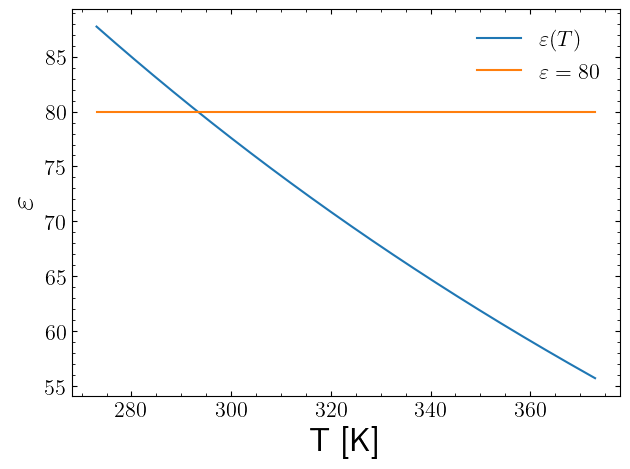

In [13]:
T = np.linspace(273, 373, 1000)
eps = 87.74 - 0.40008 * (T - 273) + 9.398e-4 * ((T - 273) ** 2) - 1.41e-6 * ((T - 273) ** 3)

fig, ax = plt.subplots()

ax.plot(T, eps, label=r'$\varepsilon (T)$')
ax.plot([T[0], T[-1]], [80, 80], label=r'$\varepsilon = 80$')

ax.set_xlabel('T [K]', fontsize=24)
ax.set_ylabel(r'$\varepsilon$', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16, framealpha=0)

fig.tight_layout()

### $\varepsilon (T)$

In [14]:
TEMPS = [x + 273 for x in [25, 30, 34]]
PHI_P = np.arange(0.00001, 0.1, 0.0003)
PHI_S = np.arange(0.00001, 0.09, 0.002)
phase_T = np.zeros((len(PHI_S) * len(PHI_P) * len(TEMPS), 5))

bnd_tol = 0
bnds = (
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
    (0 + bnd_tol, 1 - bnd_tol),
)  # bounds for phi_pa, phi_c1a, phi_c2a, phi_pia, xa

count = 0
for i, T in enumerate([x + 273 for x in [25, 30, 34]]):
    eps = 87.74 - 0.40008 * (T - 273) + 9.398e-4 * ((T - 273) ** 2) - 1.41e-6 * ((T - 273) ** 3)
    lB = (e ** 2) / (4 * np.pi * eps0 * eps * kB * T)
    t = l / (4 * np.pi * lB)
    chi_p0 = achi / (20 * np.pi * t)
    print(f'T = {T} K, lB = {lB * 1e9:.2f} nm, chi = {chi_p0:.3f}')

    for phi_s in PHI_S:
        for phi_p in PHI_P:
            phi_c1 = phi_p / 2
            phi_c2 = phi_p / 2
            phi_pi = phi_s / 2
            phi_ni = phi_s / 2
            if (phi_c1 + phi_c2 + phi_pi + phi_ni) <= 0.15:
                if ((2 * phi_p) + phi_s) <= 0.9999:
                    args = (
                        N, chi_p0, l, lB, p1, p2, phi_p, phi_c1, phi_c2, phi_pi, phi_ni,
                    )
                    pa, pb, = np.inf, np.inf
                    results = minimize(
                        dist_objective, x0=(phi_p, phi_c1, phi_c2, phi_pi, 0.1), 
                        args=args, method='Nelder-Mead', 
                        options={'fatol': 1e-16, 'xatol': 1e-16},
                        bounds=bnds,
                    )
                    if results.success:
                        pa, c1a, c2a, pia, _x = results.x
                        pb = (phi_p - _x * pa) / (1 - _x)
                        if np.abs(pa - pb) > 0.001:
                            c1b = (phi_c1 - _x * c1a) / (1 - _x)
                            c2b = (phi_c2 - _x * c2a) / (1 - _x)
                            pib = (phi_pi - _x * pia) / (1 - _x)
                            nia = pia
                            nib = (phi_ni - _x * nia) / (1 - _x)
                            phase_T[count, :] = T, c1a + c2a + pia + nia, pa, c1b + c2b + pib + nib, pb
            count += 1

T = 298 K, lB = 0.72 nm, chi = 0.443
T = 303 K, lB = 0.72 nm, chi = 0.445
T = 307 K, lB = 0.72 nm, chi = 0.448


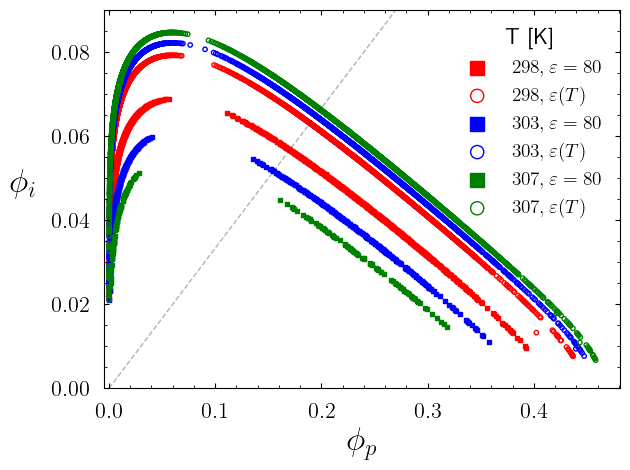

In [15]:
phase_keep_T = phase_T[phase_T.any(axis=1)]

colors = ['red', 'blue', 'green']
fig, ax = plt.subplots()
for i, T in enumerate(sorted(np.unique(phase_keep[:, 0]))):
    data = phase_keep[phase_keep[:, 0] == T, 1:]
    data_T = phase_keep_T[phase_keep_T[:, 0] == T, 1:]
    ax.scatter(data[:, 1], data[:, 0], s=10, color=colors[i], marker='s', label=rf'${T:.0f}, \varepsilon=80$')
    ax.scatter(data[:, 3], data[:, 2], s=10, color=colors[i], marker='s')
    ax.scatter(data_T[:, 1], data_T[:, 0], s=10, color=colors[i], marker='o', facecolor='none', label=rf'${T:.0f}, \varepsilon (T)$')
    ax.scatter(data_T[:, 3], data_T[:, 2], s=10, color=colors[i], marker='o', facecolor='none')

ax.plot([0, 0.3], alpha * np.array([0, 0.3]), color='black', linestyle='dashed', linewidth=1, alpha=0.3)

ax.set_xlim(-0.005, None)
ax.set_ylim(0, 0.09)
ax.set_xlabel('$\phi_{p}$', fontsize=24)
ax.set_ylabel('$\phi_{i}$', fontsize=24, rotation=0, labelpad=20)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10)

ax.legend(fontsize=14, markerscale=3, title='T [K]', title_fontsize=16, framealpha=0)

fig.tight_layout()

Ordering of envelopes switch when considering constant dielectric constant and empirical model of the dielectric constant of water, why?

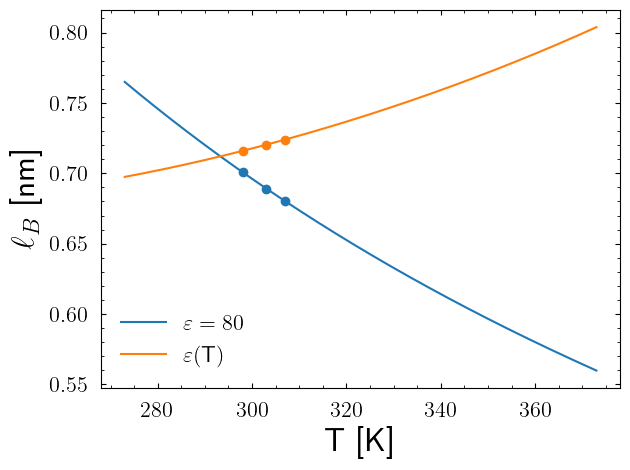

In [16]:
T = np.linspace(273, 373, 1000)

eps = 80
eps_T = 87.74 - 0.40008 * (T - 273) + 9.398e-4 * ((T - 273) ** 2) - 1.41e-6 * ((T - 273) ** 3)

lB = (e ** 2) / (4 * np.pi * eps0 * eps * kB * T)
lB_T = (e ** 2) / (4 * np.pi * eps0 * eps_T * kB * T)

fig, ax = plt.subplots()

ax.plot(T, lB * 1e9, label=r'$\varepsilon=80$')
ax.plot(T, lB_T * 1e9, label=r'$\varepsilon(\textup{T})$')

T = np.array([298, 303, 307])
eps_T = 87.74 - 0.40008 * (T - 273) + 9.398e-4 * ((T - 273) ** 2) - 1.41e-6 * ((T - 273) ** 3)
lB = (e ** 2) / (4 * np.pi * eps0 * eps * kB * T)
lB_T = (e ** 2) / (4 * np.pi * eps0 * eps_T * kB * T)
ax.scatter(T, lB * 1e9)
ax.scatter(T, lB_T * 1e9)

ax.set_xlabel('T [K]', fontsize=24)
ax.set_ylabel('$\ell_{B}$ [nm]', fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16, pad=10)
ax.legend(fontsize=16, framealpha=0)

fig.tight_layout()

The scatter points in the above plot are for the temperatures considered in the previous phase diagrams. 

We see that if we consider a constant dielectric constant, the Bjerrum length (i.e., strength of electrostatic interactions) decreases with temperature. Conversely, if we use the empirical model for the dielectric constant of water, the Bjerrum length increases with temperature. 

Since complex coacervation is mediated by electrostatic dipolar interactions, stronger dipolar interactions will result in complex coacervates that are more resistant to electrostatic screening and thus exist in higher salt concentrations.

Additionally, the phase diagrams when considering the empiricial model for the dielectric constant of water are shifted into higher salt concentrations. This is due to the electrostatic interaction strengths being stronger at all temperatures considered when compared to that when considering a constant dielectric constant.